In [1]:
# 导入所需库
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据集
data = pd.read_csv('US-pumpkins.csv')

# 数据探索
print("数据集信息：")
print(data.info())  # 查看数据类型、缺失值情况
print("\n前5行数据：")
print(data.head())  # 预览数据结构

数据集信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City Name        1757 non-null   object 
 1   Type             45 non-null     object 
 2   Package          1757 non-null   object 
 3   Variety          1752 non-null   object 
 4   Sub Variety      296 non-null    object 
 5   Grade            0 non-null      float64
 6   Date             1757 non-null   object 
 7   Low Price        1757 non-null   float64
 8   High Price       1757 non-null   float64
 9   Mostly Low       1654 non-null   float64
 10  Mostly High      1654 non-null   float64
 11  Origin           1754 non-null   object 
 12  Origin District  131 non-null    object 
 13  Item Size        1478 non-null   object 
 14  Color            1141 non-null   object 
 15  Environment      0 non-null      float64
 16  Unit of Sale     162 non-null    object 
 17  Quality

In [2]:
# 选择聚类特征
features = ['Low Price', 'High Price', 'Item Size', 'Color']

# 处理分类特征
label_encoder = LabelEncoder()
data['Item Size'] = label_encoder.fit_transform(data['Item Size'])
data['Color'] = label_encoder.fit_transform(data['Color'])

# 处理缺失值（示例）
print("\n缺失值统计：")
print(data[features].isnull().sum())
data = data.dropna(subset=features)  # 删除含有缺失值的行

# 提取特征矩阵
X = data[features]

# 标准化特征（聚类算法对尺度敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\n标准化后的特征示例：")
print(X_scaled[:5])  # 查看标准化结果


缺失值统计：
Low Price     0
High Price    0
Item Size     0
Color         0
dtype: int64

标准化后的特征示例：
[[ 1.73433451  1.6427924  -1.09936451  1.21527766]
 [ 1.73433451  1.6427924  -1.09936451  1.21527766]
 [ 0.4225106   0.30200244 -0.58358789 -0.93069505]
 [ 0.4225106   0.30200244 -0.58358789 -0.93069505]
 [-0.41228643 -0.36839253 -1.09936451 -0.93069505]]


K=2 - Inertia: 4082.70
K=3 - Inertia: 2875.01
K=4 - Inertia: 2296.48
K=5 - Inertia: 1859.40
K=6 - Inertia: 1500.72
K=7 - Inertia: 1242.41
K=8 - Inertia: 1028.10
K=9 - Inertia: 948.18
K=10 - Inertia: 845.17


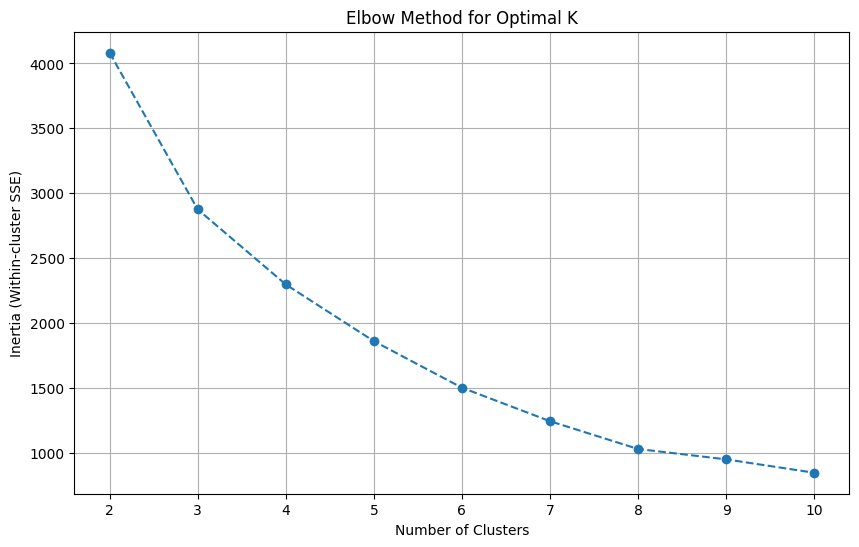

In [4]:
# 肘部法则确定最佳K值
inertia = []
k_range = range(2, 11)

plt.figure(figsize=(10, 6))
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    print(f"K={k} - Inertia: {kmeans.inertia_:.2f}")

# 绘制肘部图
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()



In [9]:
# 根据肘部图选择最佳K值
optimal_k =8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 评估聚类质量
silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
print(f"\nK-Means聚类结果 - 轮廓系数: {silhouette_avg:.4f}")


K-Means聚类结果 - 轮廓系数: 0.4926


In [10]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# 分析聚类结果
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"\nDBSCAN聚类结果：")
print(f"发现的聚类数量: {n_clusters}")
print(f"噪声点数量: {n_noise} ({n_noise/len(dbscan_labels):.1%})")

# 计算有效聚类的轮廓系数（排除噪声点）
if n_clusters > 1:
    valid_mask = (dbscan_labels != -1)
    if sum(valid_mask) > 1:  # 需要至少2个样本才能计算轮廓系数
        silhouette_avg = silhouette_score(
            X_scaled[valid_mask], 
            dbscan_labels[valid_mask]
        )
        print(f"DBSCAN轮廓系数 (排除噪声点): {silhouette_avg:.4f}")


DBSCAN聚类结果：
发现的聚类数量: 45
噪声点数量: 48 (2.7%)
DBSCAN轮廓系数 (排除噪声点): 0.4852


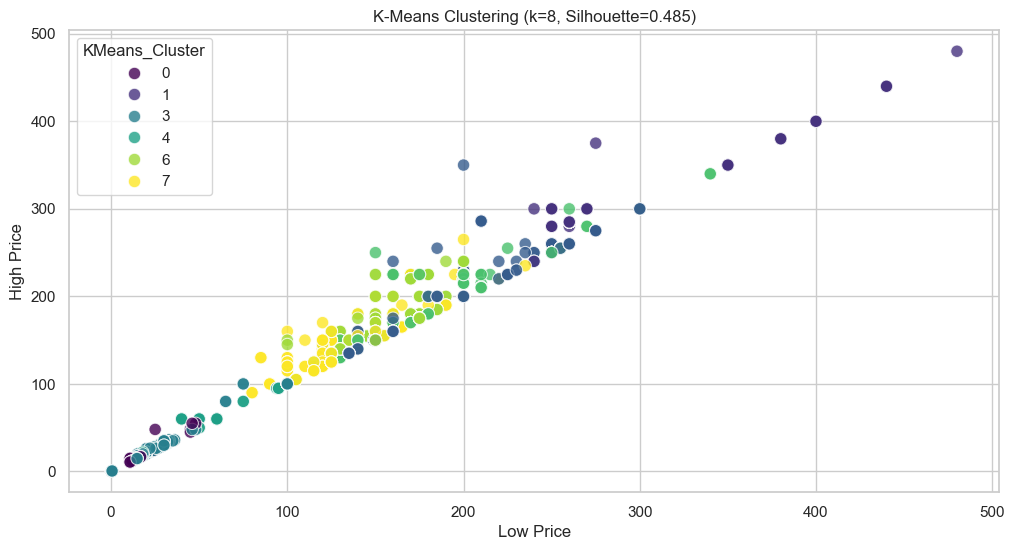

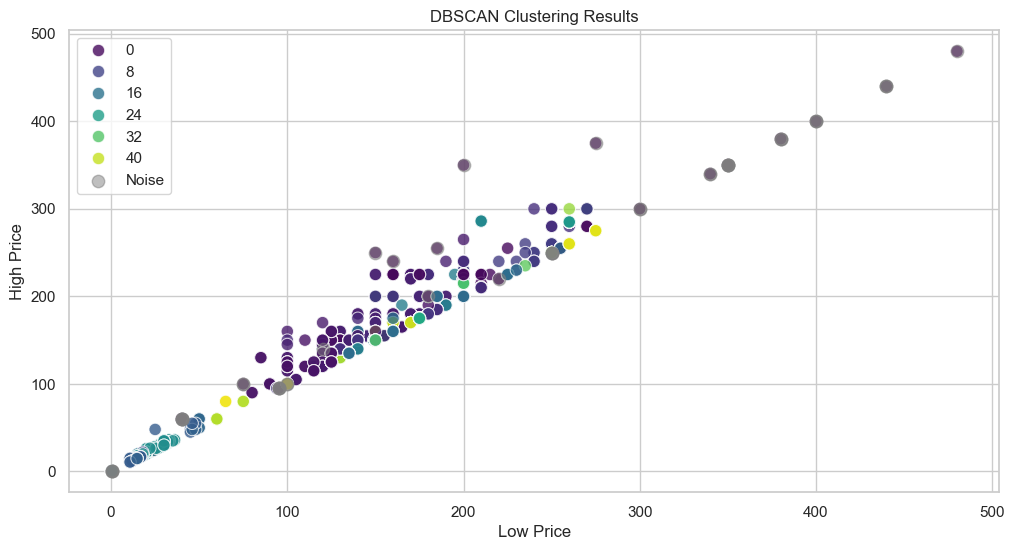

In [28]:
# 将聚类结果添加到原始数据
data['KMeans_Cluster'] = kmeans_labels
data['DBSCAN_Cluster'] = dbscan_labels

# K-Means可视化
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Low Price', 
    y='High Price',
    hue='KMeans_Cluster', 
    data=data,
    palette='viridis',
    s=80,
    alpha=0.8
)
plt.title(f'K-Means Clustering (k={optimal_k}, Silhouette={silhouette_avg:.3f})')
plt.grid(True)
plt.show()

# DBSCAN可视化
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x='Low Price', 
    y='High Price',
    hue='DBSCAN_Cluster', 
    data=data,
    palette='viridis',
    s=80,
    alpha=0.8
)
plt.title('DBSCAN Clustering Results')
plt.grid(True)

# 添加噪声点标注
if n_noise > 0:
    noise_points = data[data['DBSCAN_Cluster'] == -1]
    plt.scatter(
        noise_points['Low Price'],
        noise_points['High Price'],
        s=80,
        c='gray',
        alpha=0.5,
        label='Noise'
    )
    plt.legend()
plt.show()

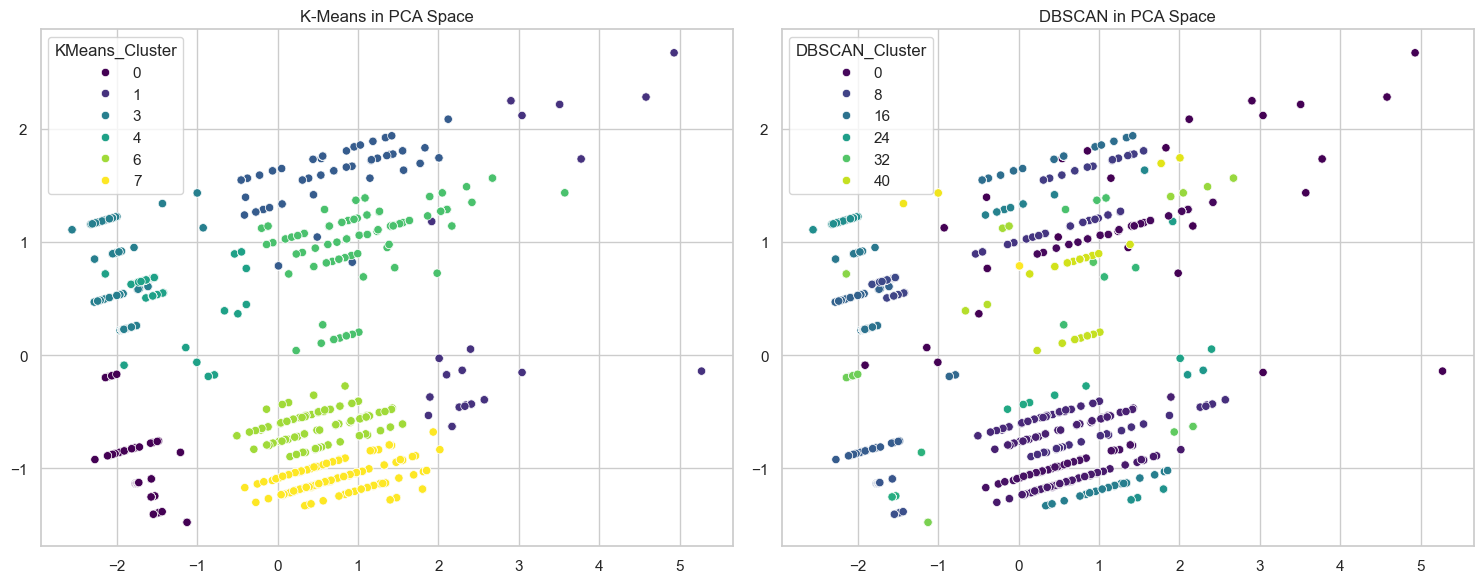

In [29]:
# 多维度分析（使用PCA降维）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=data['KMeans_Cluster'],
    palette='viridis'
)
plt.title('K-Means in PCA Space')

plt.subplot(122)
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=data['DBSCAN_Cluster'],
    palette='viridis'
)
plt.title('DBSCAN in PCA Space')
plt.tight_layout()
plt.show()

C:\Users\86182\AppData\Local\Temp\ipykernel_18168\1221196497.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
C:\Users\86182\AppData\Local\Temp\ipykernel_18168\1221196497.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
C:\Users\86182\AppData\Local\Temp\ipykernel_18168\1221196497.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
C:\Users\86182\AppData\Lo

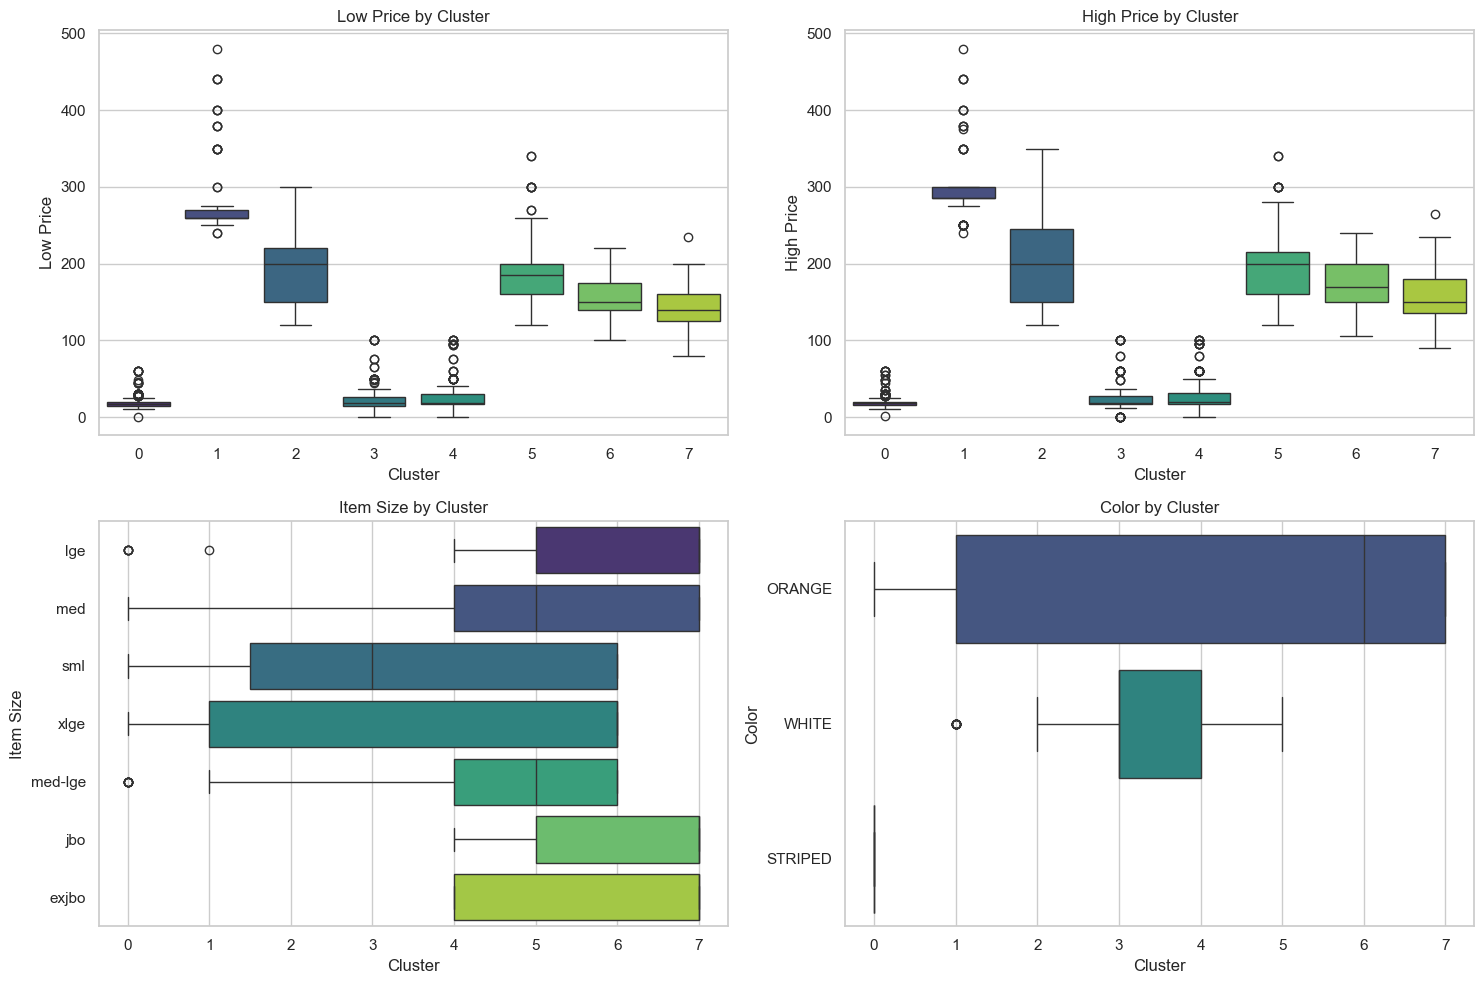

In [30]:
# 聚类特征分布箱线图
plt.figure(figsize=(15, 10))

# 为每个特征创建子图
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


K-Means聚类中心：
    Low Price  High Price  Item Size         Color
0   20.086340   21.057216   5.530928  6.185567e-02
1  278.809524  299.047619   5.466667  6.380952e-01
2  192.535433  202.732283   5.960630  2.889764e+00
3   22.771718   24.458740   6.045802  2.511450e+00
4   28.727206   30.550735   2.669118  2.845588e+00
5  188.677536  192.065217   2.478261  2.880435e+00
6  156.472727  173.896364   5.236364 -4.440892e-16
7  147.303665  159.694372   2.052356  4.440892e-16

聚类分组统计：

Cluster 0 (194 samples):
      Low Price  High Price
mean   20.08634   21.057216
50%    17.00000   18.000000

Cluster 1 (105 samples):
       Low Price  High Price
mean  278.809524  299.047619
50%   260.000000  285.000000

Cluster 2 (127 samples):
       Low Price  High Price
mean  192.535433  202.732283
50%   200.000000  200.000000

Cluster 3 (262 samples):
      Low Price  High Price
mean  22.771718    24.45874
50%   18.000000    18.00000

Cluster 4 (136 samples):
      Low Price  High Price
mean  28.727206   

C:\Users\86182\AppData\Local\Temp\ipykernel_18168\162728557.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


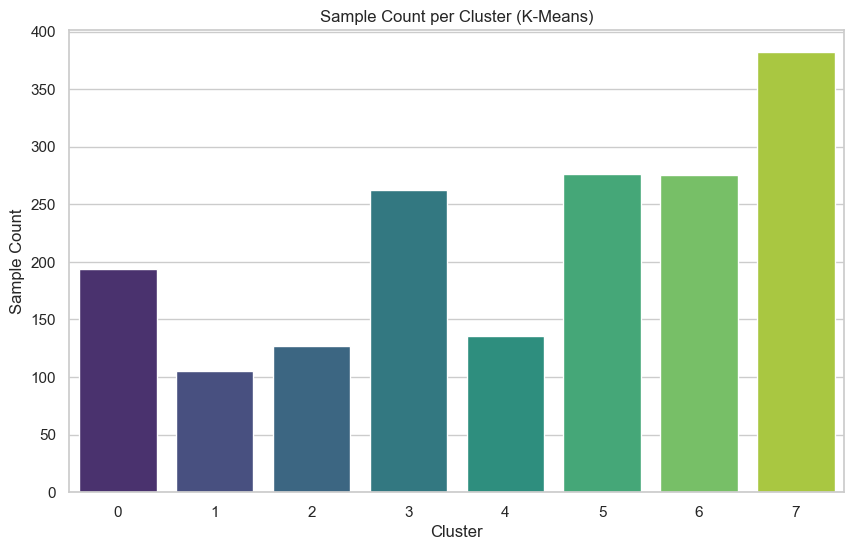

In [31]:
# 添加原始特征用于分析
data['PC1'] = X_pca[:, 0]
data['PC2'] = X_pca[:, 1]

# 分析聚类特征
print("\nK-Means聚类中心：")
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_df = pd.DataFrame(cluster_centers, columns=features)
print(cluster_df)

# 分组统计特征
print("\n聚类分组统计：")
for cluster in sorted(data['KMeans_Cluster'].unique()):
    cluster_data = data[data['KMeans_Cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} samples):")
    print(cluster_data[features].describe().loc[['mean', '50%']])

# 分析每个聚类的样本数量
cluster_counts = data['KMeans_Cluster'].value_counts().sort_index()
print("\nK-Means聚类样本数量：")
print(cluster_counts)

# 可视化每个聚类的样本数量
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Sample Count per Cluster (K-Means)')
plt.xlabel('Cluster')
plt.ylabel('Sample Count')
plt.show()

C:\Users\86182\AppData\Local\Temp\ipykernel_18168\3728334094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_df.index, y=cluster_df[feature], palette='viridis')
C:\Users\86182\AppData\Local\Temp\ipykernel_18168\3728334094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_df.index, y=cluster_df[feature], palette='viridis')
C:\Users\86182\AppData\Local\Temp\ipykernel_18168\3728334094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_df.index, y=cluster_df[feature], palette='viridis')
C:\Users\86182\AppData

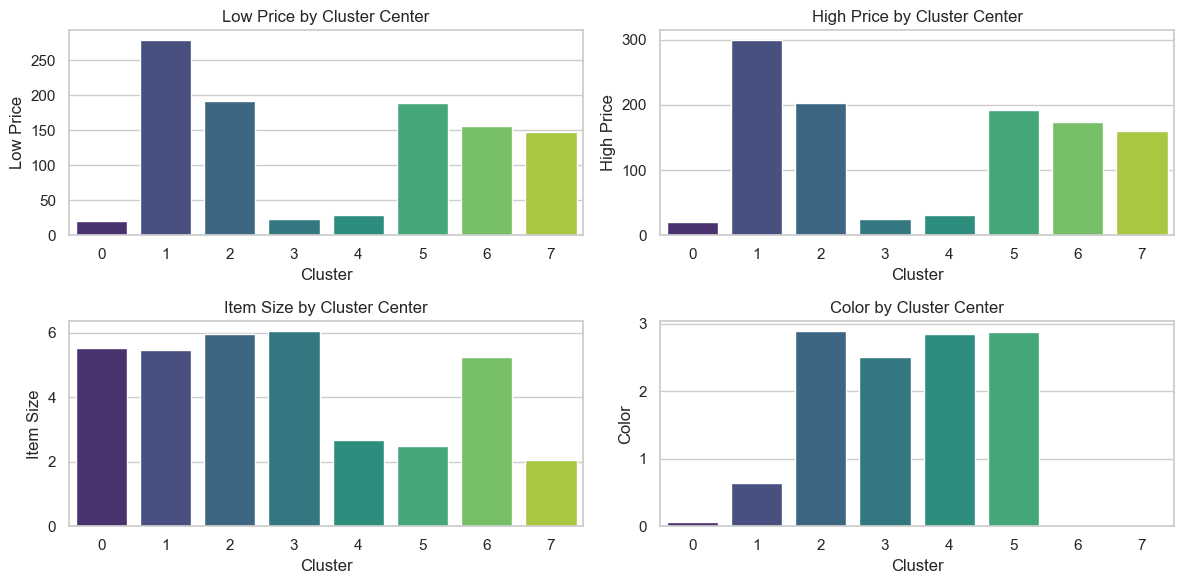

C:\Users\86182\AppData\Local\Temp\ipykernel_18168\3728334094.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
C:\Users\86182\AppData\Local\Temp\ipykernel_18168\3728334094.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
C:\Users\86182\AppData\Local\Temp\ipykernel_18168\3728334094.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
C:\Users\8618

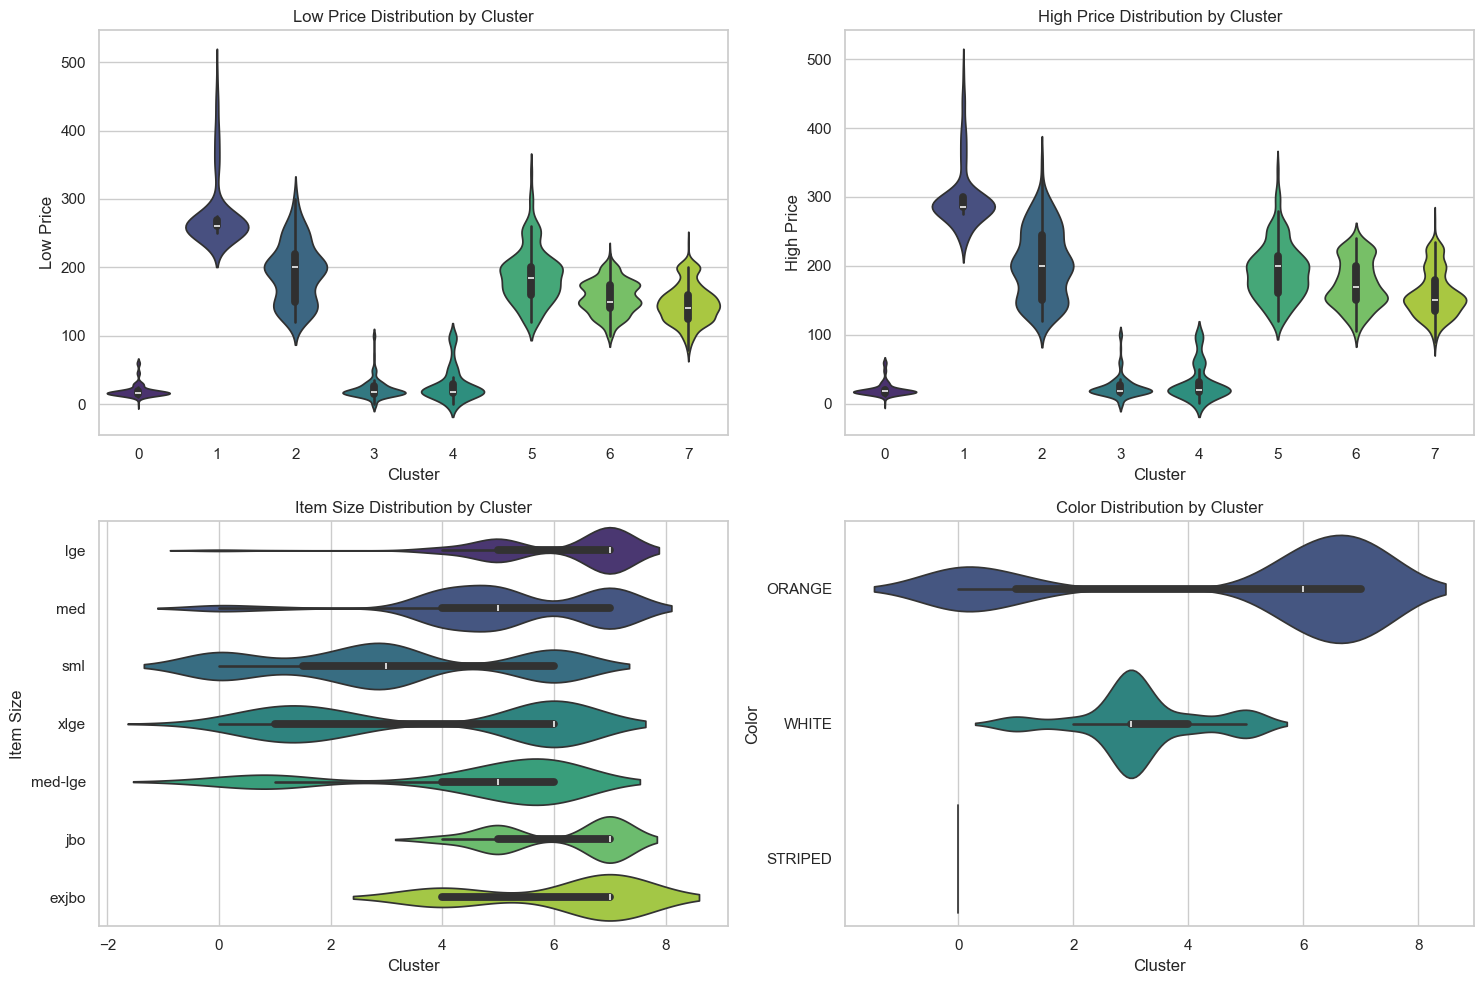

In [32]:
# 可视化聚类中心的特征值
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=cluster_df.index, y=cluster_df[feature], palette='viridis')
    plt.title(f'{feature} by Cluster Center')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# 可视化每个聚类在各个特征上的分布
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x='KMeans_Cluster', y=feature, data=data, palette='viridis')
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()